In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install aws-fortuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.9/336.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.2/227.2 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: flax
    Found existing installation: flax 0.8.1
    Uninstalling flax-0.8.1:
      Successfully uninstalled flax-0.8.1


In [ ]:
import time
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

import sys
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import sklearn
import sklearn.model_selection
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(20000))

###
mnist_calib_dataset, mnist_valid_dataset = random_split(mnist_valid_dataset, [10000, 10000])
###

mnist_train_dataset = Subset(mnist_dataset, torch.arange(20000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 402986471.17it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42758804.74it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 228104205.17it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 15000416.35it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

###
calib_dl = DataLoader(mnist_calib_dataset, batch_size=10000, shuffle=True)#, pin_memory=True)
###

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [ ]:

model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [ ]:

model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [ ]:

try:
    device = torch.device("cuda:0")
    model = model.to(device)
    print("Model connected to gpu.")
except RuntimeError as e:
    print(f"RuntimeError: {e}")
    device = torch.device("cpu")
    model = model.to(device)
    print("Model connected to cpu.")

Model connected to gpu.


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9394 val_accuracy: 0.9821
Epoch 2 accuracy: 0.9812 val_accuracy: 0.9870
Epoch 3 accuracy: 0.9876 val_accuracy: 0.9888
Epoch 4 accuracy: 0.9901 val_accuracy: 0.9904
Epoch 5 accuracy: 0.9926 val_accuracy: 0.9892
Epoch 6 accuracy: 0.9941 val_accuracy: 0.9889
Epoch 7 accuracy: 0.9947 val_accuracy: 0.9911
Epoch 8 accuracy: 0.9944 val_accuracy: 0.9907
Epoch 9 accuracy: 0.9957 val_accuracy: 0.9913
Epoch 10 accuracy: 0.9965 val_accuracy: 0.9897
Epoch 11 accuracy: 0.9968 val_accuracy: 0.9919
Epoch 12 accuracy: 0.9967 val_accuracy: 0.9913
Epoch 13 accuracy: 0.9972 val_accuracy: 0.9894
Epoch 14 accuracy: 0.9976 val_accuracy: 0.9925
Epoch 15 accuracy: 0.9970 val_accuracy: 0.9905
Epoch 16 accuracy: 0.9980 val_accuracy: 0.9909
Epoch 17 accuracy: 0.9978 val_accuracy: 0.9911
Epoch 18 accuracy: 0.9977 val_accuracy: 0.9915
Epoch 19 accuracy: 0.9980 val_accuracy: 0.9929
Epoch 20 accuracy: 0.9988 val_accuracy: 0.9916


In [28]:
model_path = '/content/sample_data'

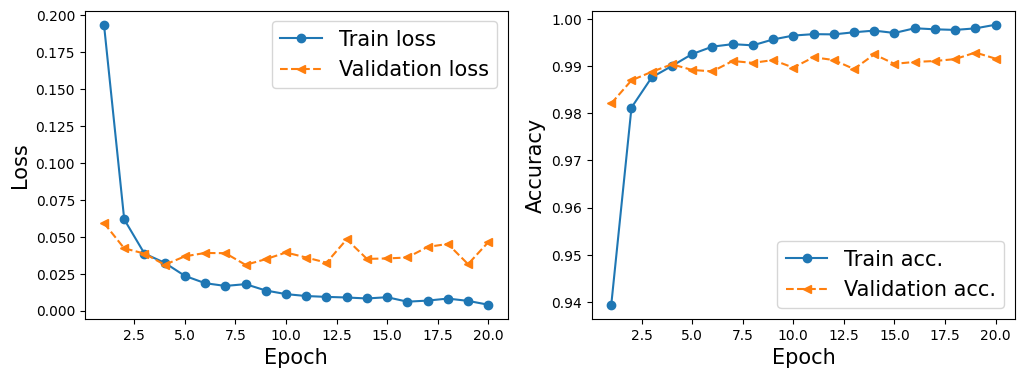

In [ ]:
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [ ]:
torch.cuda.synchronize()
model_cpu = model.cpu()
test_preds = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(test_preds, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9934


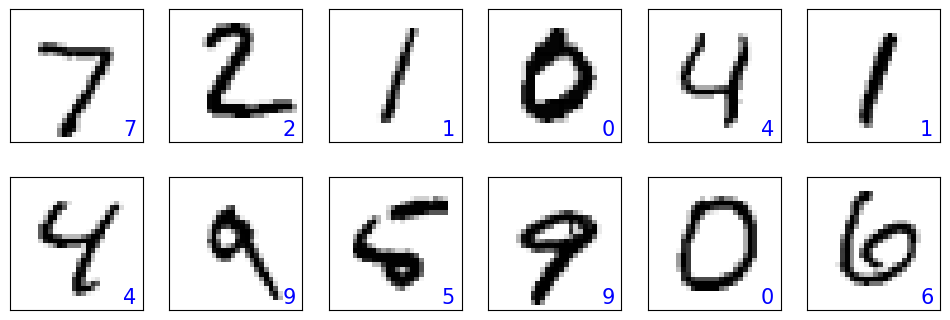

In [ ]:

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)


#plt.savefig('figures/14_14.png')
plt.show()

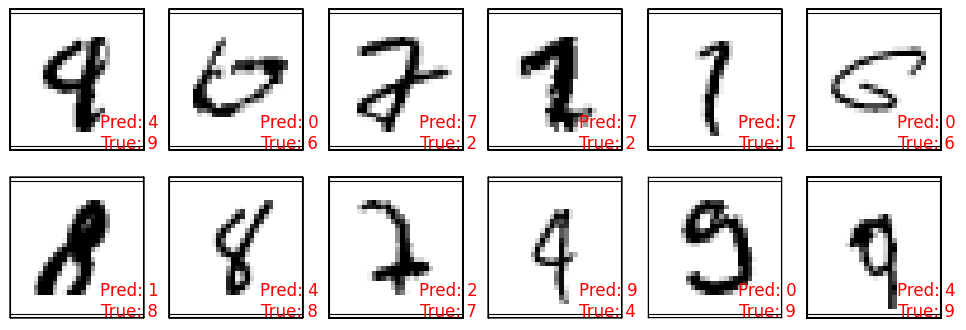

In [ ]:
fig = plt.figure(figsize=(12, 4))
misclassified_count = 0

for i in range(len(mnist_test_dataset)):
    ax = fig.add_subplot(2, 6, misclassified_count + 1)
    ax.set_xticks([]); ax.set_yticks([])
    img, true_label = mnist_test_dataset[i]
    img = img[0]  # Extracting the image tensor
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)

    if y_pred != true_label:
        ax.imshow(img, cmap='gray_r')
        ax.text(0.9, 0.1, f'Pred: {y_pred.item()}\nTrue: {true_label}',
                size=12, color='red',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
        misclassified_count += 1

    if misclassified_count >= 12:
        break

plt.show()

**Integrated Gradients**

In [30]:
def integrated_gradients(model, data, target, n_iter, device='cuda', visualize=True):
    assert isinstance(data, np.ndarray), "data should be np.ndarray type"
    assert data.ndim == 4, "(n_batch, n_feat, h, w)"

    input_x = torch.from_numpy(data).float().to(device)
    baseline = torch.from_numpy(np.random.random(size=(input_x.shape))).float().to(device)

    alpha = np.linspace(0, 1, n_iter)
    alpha = torch.from_numpy(alpha).float().to(device)
    alpha = alpha.view(n_iter, *tuple(np.ones(baseline[0].ndim, dtype='int')))

    attributions = []
    for i in range(input_x.shape[0]):
        x = input_x[i].unsqueeze(0)
        base = baseline[i].unsqueeze(0)
        scaled_x = base + alpha * (x - base)
        attribution = torch.zeros(*scaled_x.shape)
        for i in range(n_iter):
            part_scaled_x = scaled_x[i:i+1]
            part_scaled_x.requires_grad = True
            part_y_hat = model(part_scaled_x)[:, target]
            attribution[i] = torch.autograd.grad(part_y_hat, part_scaled_x)[0]
        integrated = attribution.sum(axis=0) / n_iter
        ig = (x - base) * integrated
        ig = ig.detach().cpu().numpy().squeeze()
        attributions.append(ig)
    attributions = np.array(attributions)

    if visualize:
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(data.reshape(28, 28, 1), cmap='bone_r')
        plt.grid()
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(attributions.reshape(28, 28, 1), cmap='bone_r')
        plt.grid()
        plt.axis('off')
        plt.show()

    return attributions

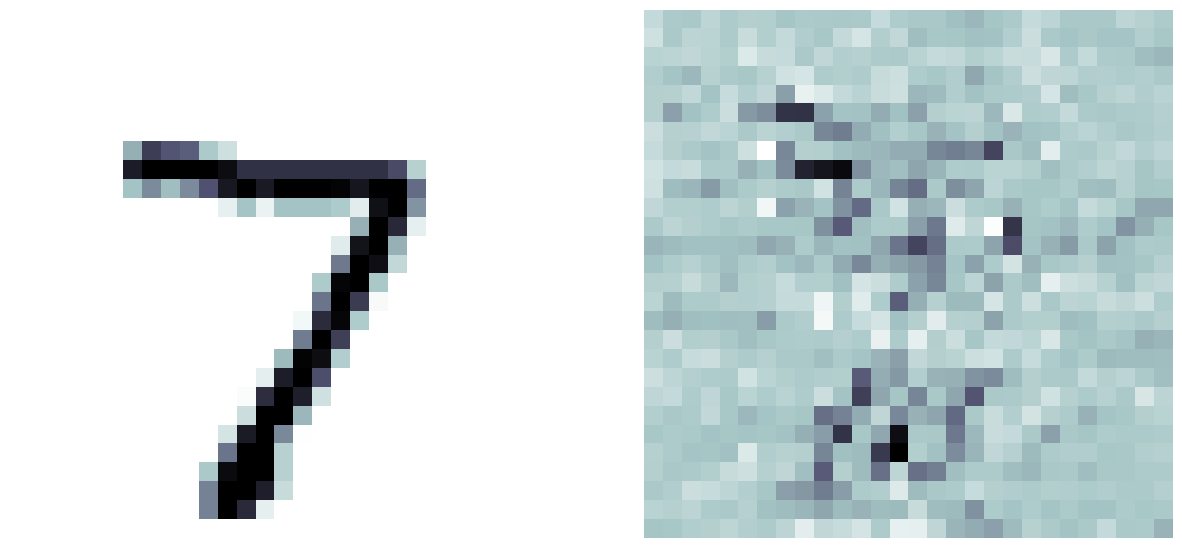

In [46]:
image, target = mnist_test_dataset[0][0].numpy(), mnist_test_dataset.targets[0].item()

# Prepare the image data and target for the integrated_gradients function
# The function expects a 4D array (n_batch, n_feat, h, w)
data = image.reshape(1, 1, 28, 28)  # Reshape the image to have batch dimension
target_class = target  # The target class for which to calculate attributions

# Specify the number of steps for the integrated gradients calculation
n_iter = 50

# Assuming 'device' is defined (as 'cuda' or 'cpu') according to your model's device
# If not, ensure your model is already moved to the desired device
device = next(model.parameters()).device

# Run the integrated gradients
ig_attr = integrated_gradients(model,
                               data,
                               target_class,
                               n_iter,
                               device=device,
                               visualize=True)

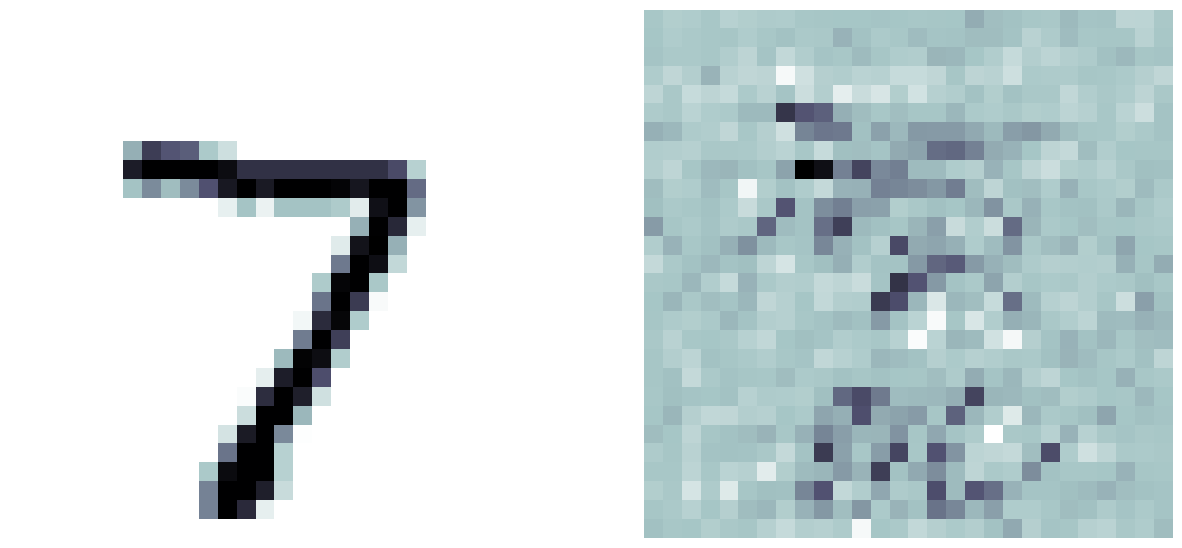

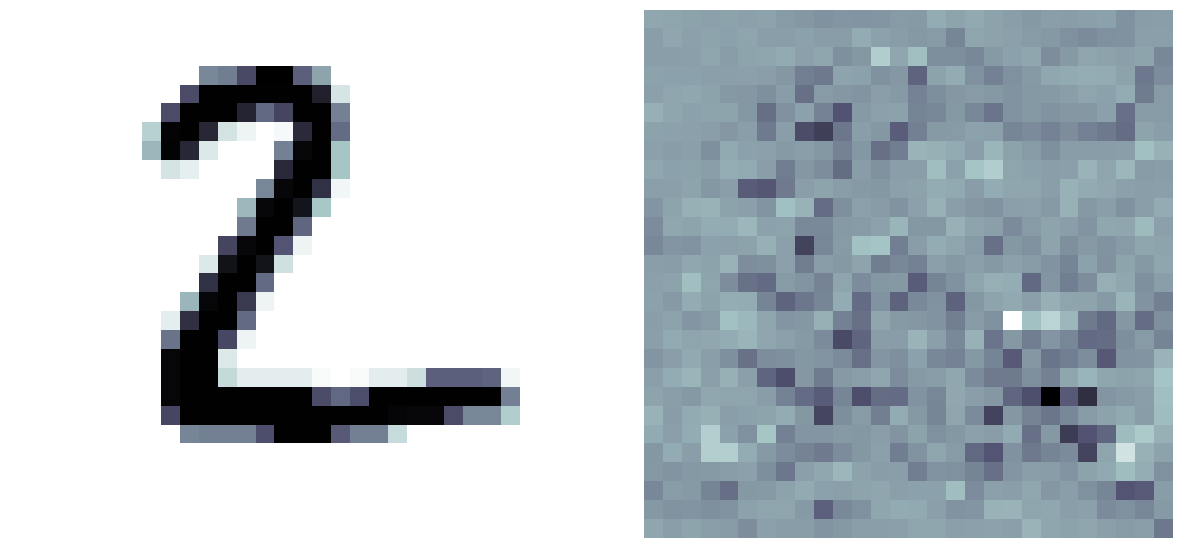

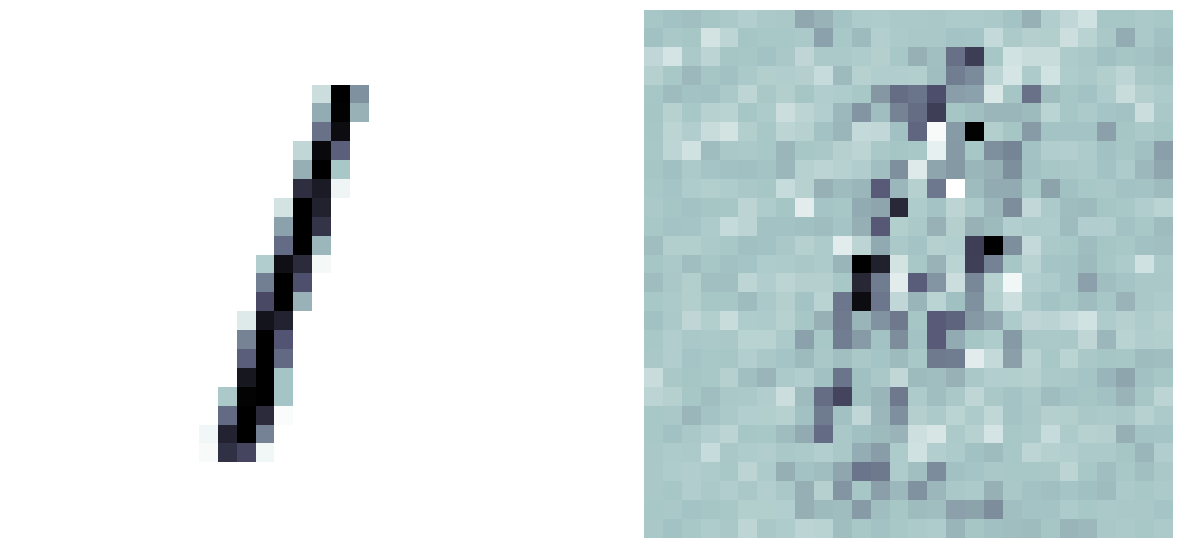

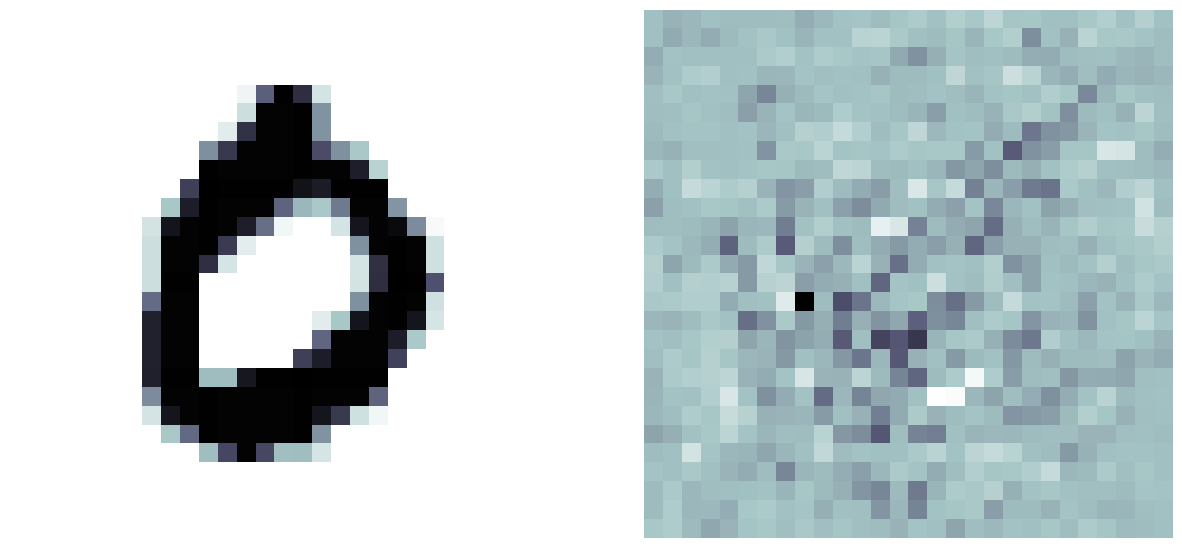

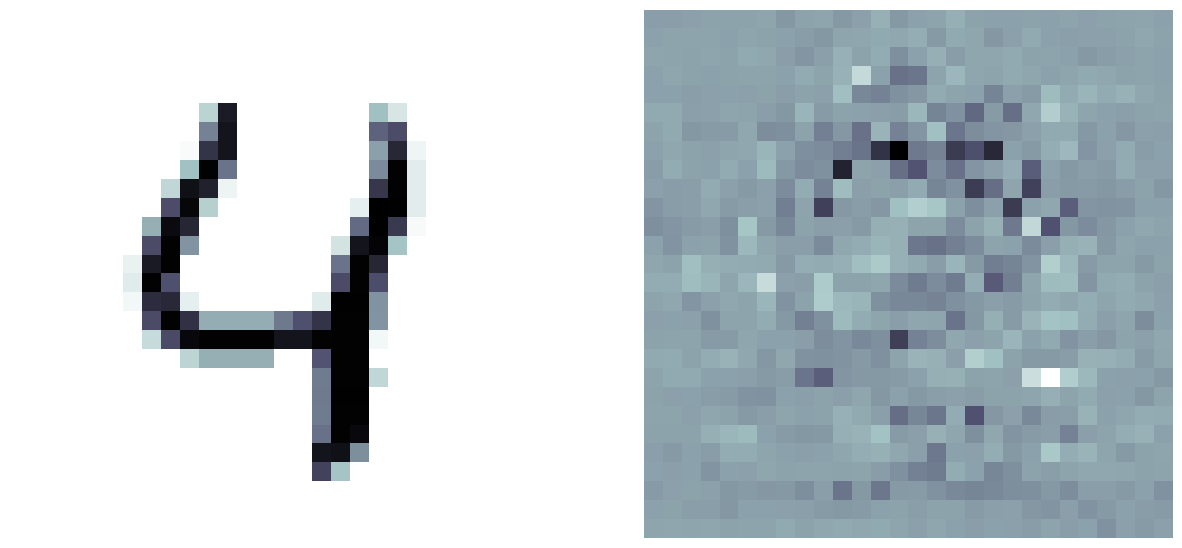

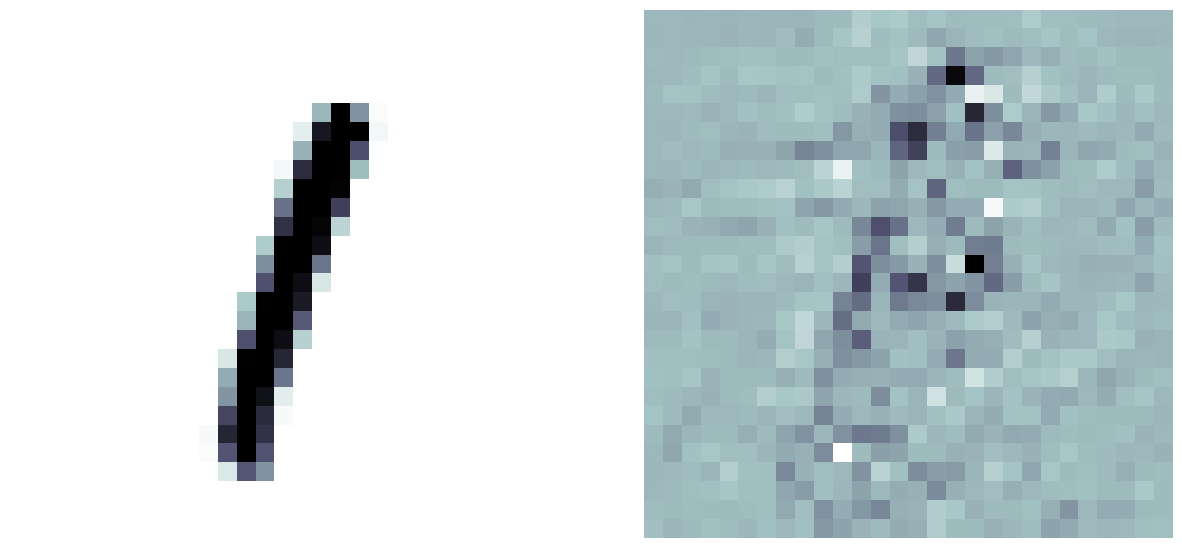

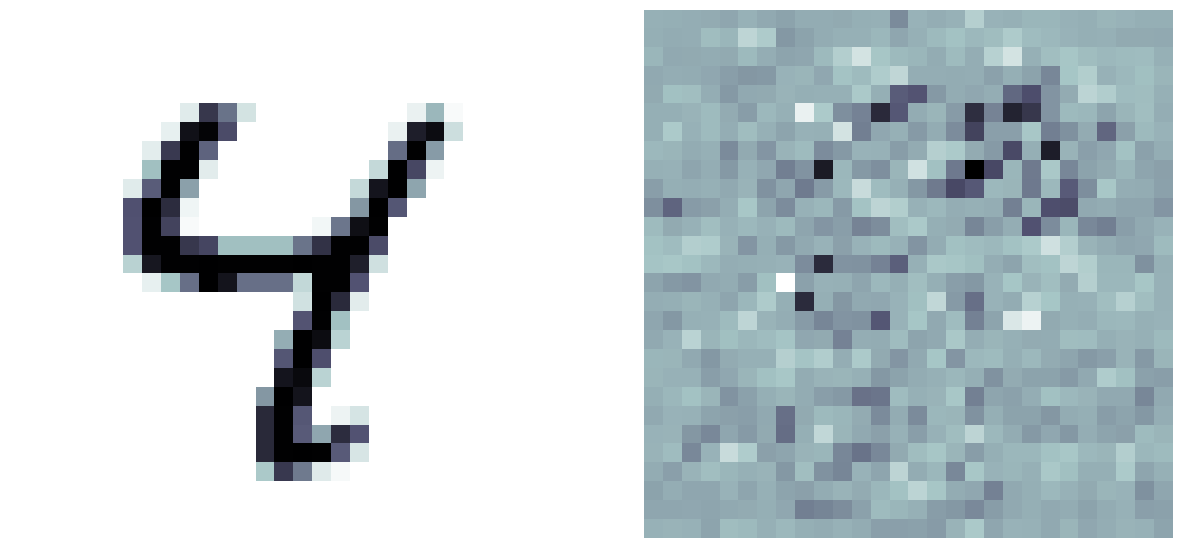

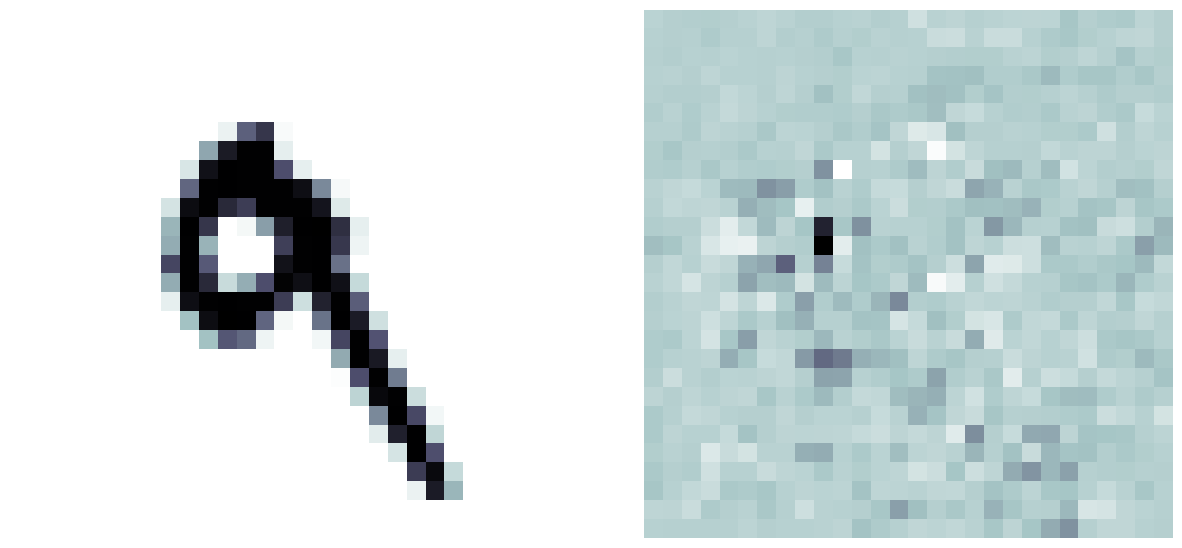

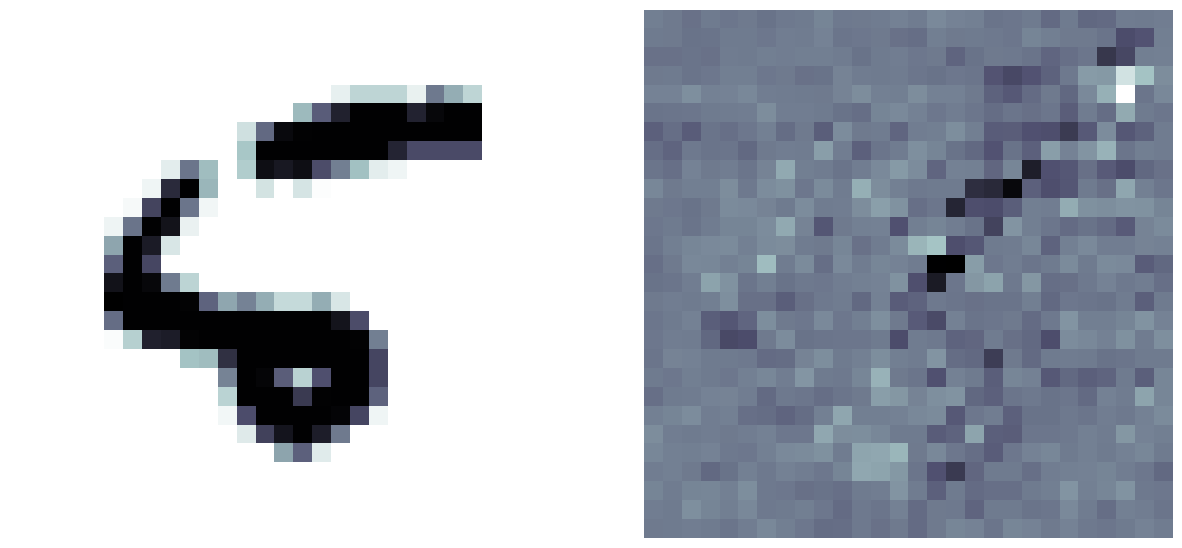

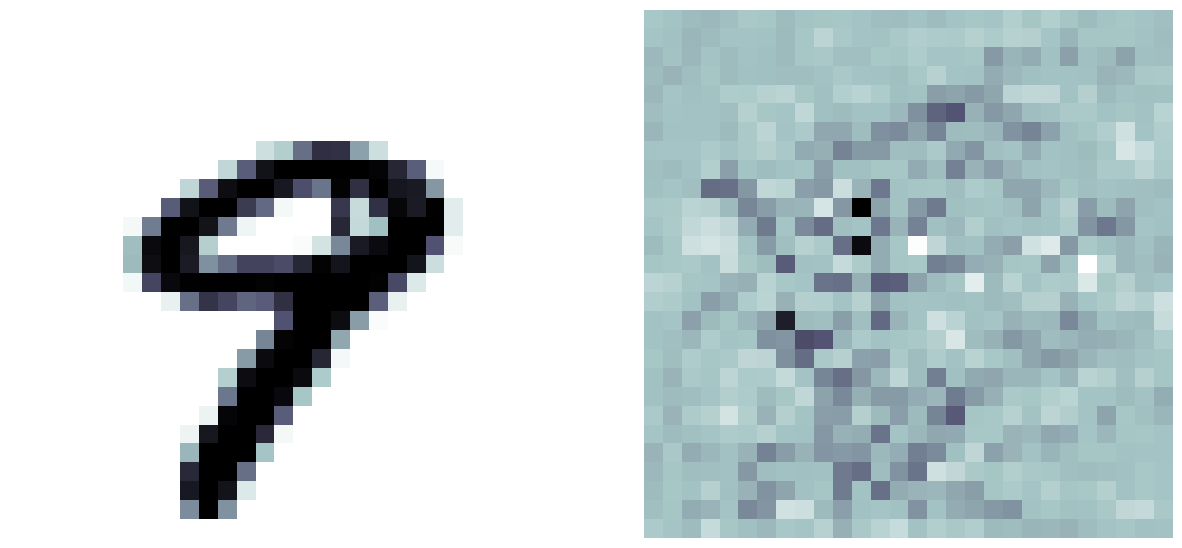

In [64]:
# Loop over the test DataLoader to get the first batch
for images, targets in test_dl:
    # Convert images to numpy array directly without calling .numpy() on tensors
    images_np = images.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()
    break  # Only process the first batch

# Now, `images_np` is an np.ndarray that you can use with the integrated_gradients function
# Iterate over each image in the batch to calculate attributions
for i in range(len(images_np)):
    image = images_np[i]
    target = targets_np[i]
    data = image.reshape(1, 1, 28, 28)  # Reshape for integrated_gradients
    target_class = target  # The target class for which to calculate attributions

    # Ensure the device is correctly set for PyTorch operations
    device = next(model.parameters()).device
    model.to(device)

    # No need to convert `data` to a tensor here, use it directly
    ig_attr = integrated_gradients(model,
                                   data,
                                   target_class,
                                   n_iter=50,
                                   device=device,
                                   visualize=True)


Sample images from the test dataset and their attributions.

The first column shows the original image.

The second column shows the values of the attributions.

The third column shows the positive valued attributions.

The fourth column shows the negative valued attributions.

The attributions are calculated using the black image as a baseline for all samples.


In [74]:
test_dl = DataLoader(mnist_test_dataset, batch_size=10, shuffle=False)

In [65]:
# Process the first batch
for images, targets in test_dl:
    images, targets = images.to(device), targets.to(device)
    images_np = images.cpu().numpy()
    break  # Only take the first batch

In [66]:
attributions_batch = []

# Calculate attributions for the first batch
for i in range(images_np.shape[0]):
    data = images_np[i].reshape(1, 1, 28, 28)
    target_class = targets[i].item()
    attributions = integrated_gradients(model, data, target_class, 50, device=device, visualize=False)
    attributions_batch.append(attributions)

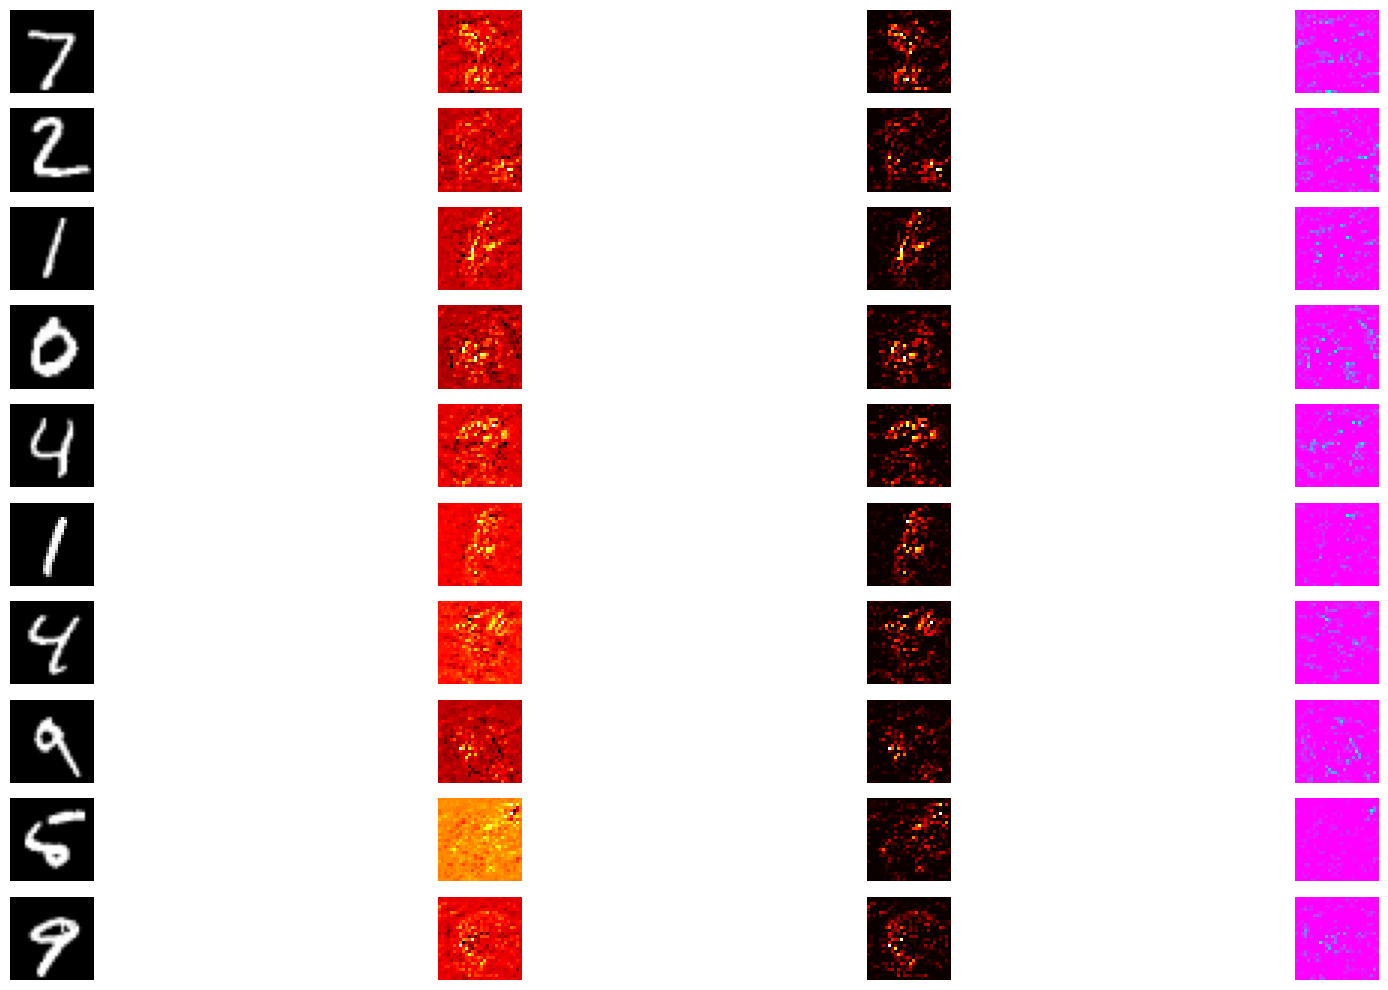

In [68]:
# Visualization
fig, axs = plt.subplots(len(images_np), 4, figsize=(20, 10))  # Adjust size as needed

for i, (image, attr) in enumerate(zip(images_np, attributions_batch)):
    axs[i, 0].imshow(image.squeeze(), cmap='gray')
    axs[i, 1].imshow(attr.squeeze(), cmap='hot', interpolation='nearest')
    axs[i, 2].imshow(np.maximum(0, attr).squeeze(), cmap='hot', interpolation='nearest')
    axs[i, 3].imshow(np.minimum(0, attr).squeeze(), cmap='cool', interpolation='nearest')
    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [80]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00


In [81]:
from captum.attr import IntegratedGradients

In [82]:
n_steps = 50
ig = IntegratedGradients(model)


In [83]:
# Retrieve the first batch of test data
test_images, test_labels = next(iter(test_dl))
test_images = test_images.to(device)
test_labels = test_labels.to(device)

In [84]:
# Calculate attributions using IntegratedGradients
attributions = ig.attribute(test_images, target=test_labels, n_steps=n_steps)

# Prepare predictions
predictions = model(test_images).max(1)[1].cpu().numpy()

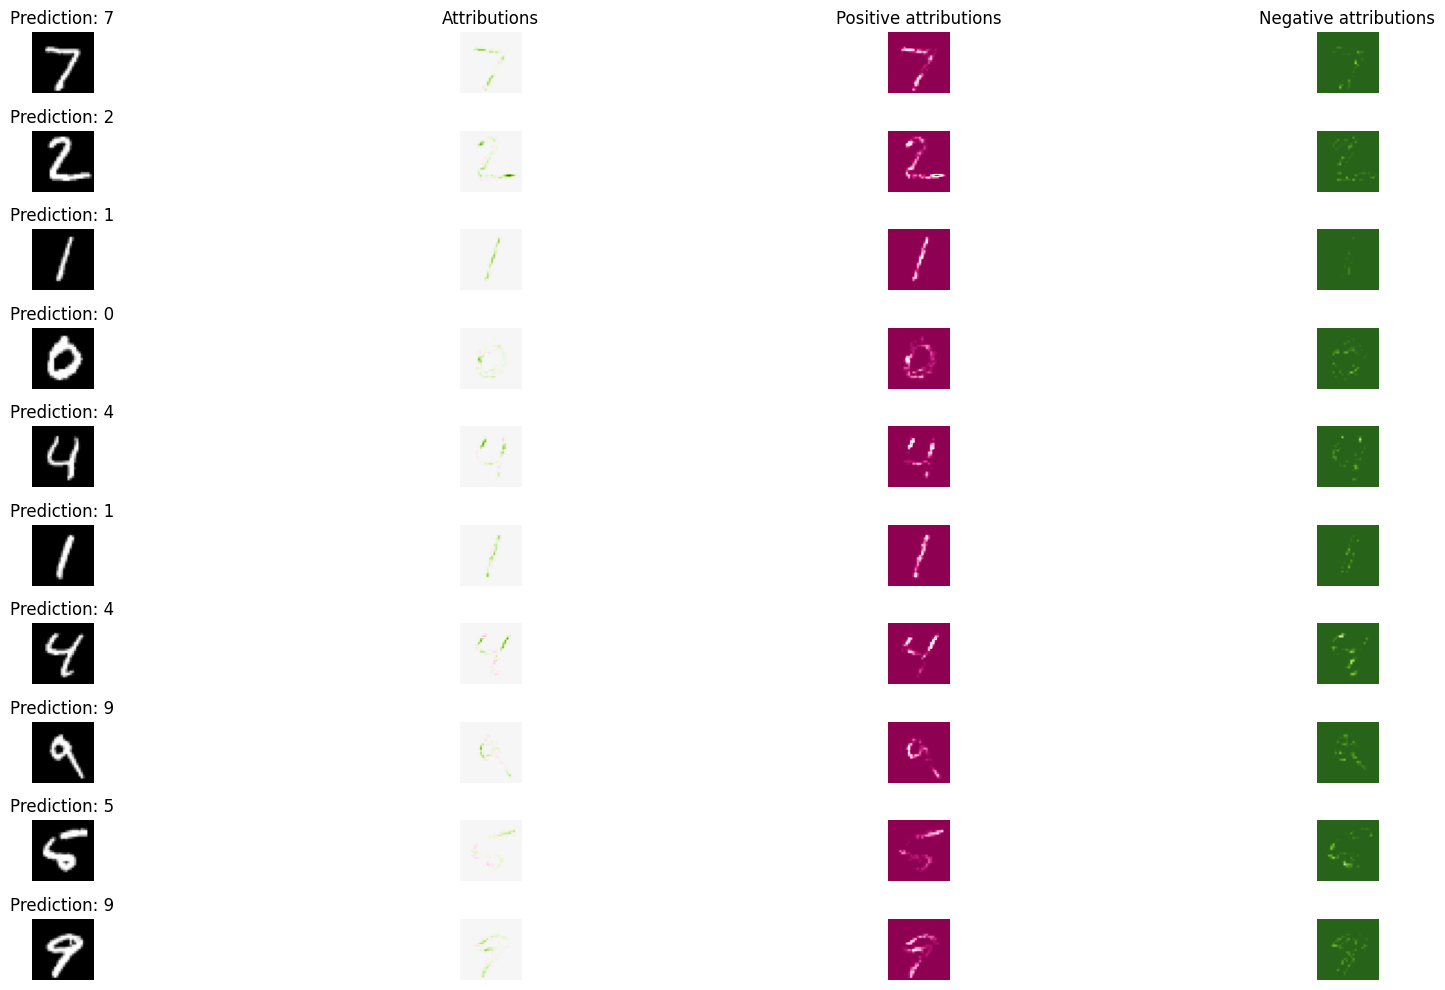

In [91]:
# Visualize
fig, axs = plt.subplots(len(test_images), 4, figsize=(20, 10))

# Use a global color bound for all images
cmap_bound = torch.max(torch.abs(attributions)).cpu().numpy()

for i, (image, attr) in enumerate(zip(test_images.cpu().numpy(), attributions.cpu().numpy())):
    # Original image
    axs[i, 0].imshow(image.squeeze(), cmap='gray')
    axs[i, 0].set_title(f'Prediction: {predictions[i]}')

    # Attributions
    axs[i, 1].imshow(attr.squeeze(), cmap='PiYG', vmin=-cmap_bound, vmax=cmap_bound)

    # Positive attributions
    axs[i, 2].imshow(np.maximum(0, attr).squeeze(), cmap='PiYG', vmin=0, vmax=cmap_bound)

    # Negative attributions
    axs[i, 3].imshow(np.minimum(0, attr).squeeze(), cmap='PiYG', vmin=-cmap_bound, vmax=0)

    axs[0, 1].set_title('Attributions');
    axs[0, 2].set_title('Positive attributions');
    axs[0, 3].set_title('Negative attributions');

    for ax in axs[i]:
        ax.axis('off')
plt.tight_layout()
plt.show()

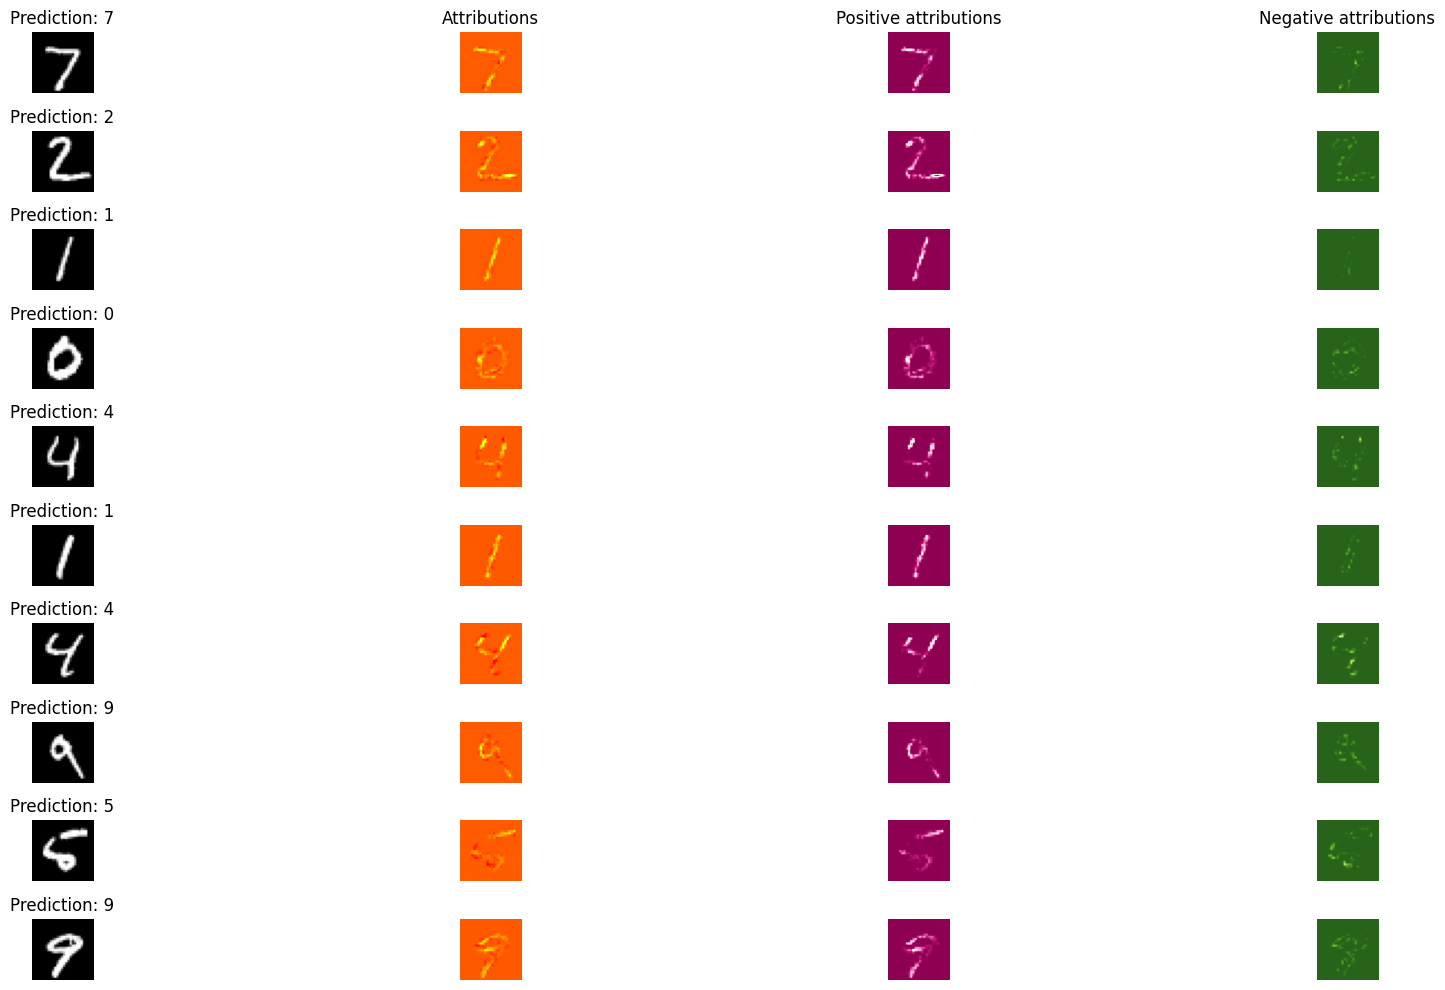

In [93]:
# Visualize
fig, axs = plt.subplots(len(test_images), 4, figsize=(20, 10))

# Use a global color bound for all images
cmap_bound = torch.max(torch.abs(attributions)).cpu().numpy()

for i, (image, attr) in enumerate(zip(test_images.cpu().numpy(), attributions.cpu().numpy())):
    # Original image
    axs[i, 0].imshow(image.squeeze(), cmap='gray')
    axs[i, 0].set_title(f'Prediction: {predictions[i]}')

    # Attributions
    axs[i, 1].imshow(attr.squeeze(), cmap='hot', vmin=-cmap_bound, vmax=cmap_bound)

    # Positive attributions
    axs[i, 2].imshow(np.maximum(0, attr).squeeze(), cmap='PiYG', vmin=0, vmax=cmap_bound)

    # Negative attributions
    axs[i, 3].imshow(np.minimum(0, attr).squeeze(), cmap='PiYG', vmin=-cmap_bound, vmax=0)

    axs[0, 1].set_title('Attributions');
    axs[0, 2].set_title('Positive attributions');
    axs[0, 3].set_title('Negative attributions');

    for ax in axs[i]:
        ax.axis('off')
plt.tight_layout()
plt.show()

**Expected Gradients**

In [31]:
def expected_gradients(model, data, baseline, target, n_iter, device='cuda', visualize=True):
    assert isinstance(data, np.ndarray),    "data should be np.ndarray type"
    assert data.ndim == 4, "(n_batch, n_feat, h, w)"
    assert isinstance(baseline, np.ndarray), "baseline should be np.ndarray type"
    assert baseline.ndim == 4, "(n_batch, n_feat, h, w)"

    input_x = torch.from_numpy(data).float().to(device)
    replace = baseline.shape[0] < n_iter
    sample_idx = np.random.choice(baseline.shape[0], size=(input_x.shape[0], n_iter), replace=replace)
    sampled_baseline = torch.from_numpy(baseline[sample_idx]).float().cuda()

    alpha = np.linspace(0, 1, n_iter)
    alpha = torch.from_numpy(alpha).float().to(device)
    alpha = alpha.view(n_iter, *tuple(np.ones(baseline[0].ndim, dtype='int')))

    attributions = []
    for i in range(input_x.shape[0]):
        x = input_x[i].unsqueeze(0)
        ref = sampled_baseline[i]
        scaled_x = ref + alpha * (x - ref)
        attribution = torch.zeros(*scaled_x.shape).to(device)
        for i in range(n_iter):
            part_scaled_x = scaled_x[i:i+1]
            part_scaled_x.requires_grad = True
            part_y_hat = model(part_scaled_x)[:, target]
            attribution[i] = torch.autograd.grad(part_y_hat, part_scaled_x)[0]
        integrated = attribution.sum(axis=0) / n_iter
        ig = (x - ref).mean(axis=0) * integrated
        ig = ig.detach().cpu().numpy().squeeze()
        attributions.append(ig)
    attributions = np.array(attributions)

    if visualize:
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(data.reshape(28, 28, 1), cmap='bone_r')
        plt.grid()
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(attributions.reshape(28, 28, 1), cmap='bone_r')
        plt.grid()
        plt.axis('off')
        plt.show()

    return attribution

In [ ]:
model.eval()  # Set model to evaluation mode


# Replace these values with actual data appropriate for your model
data = np.random.rand(1, 3, 28, 28)  # Example input: 1 image, 3 channels, 28x28 size
target = 0  # Example target class index
n_iter = 50  # Number of steps for integration
device = 'cuda'

# Ensure the model and data processing device is consistent
model.to(device)

# Run integrated gradients
ig_attr = integrated_gradients(model,
                               data,
                               target,
                               n_iter,
                               device=device,
                               visualize=True)